# Save time by reusing regridder

There is an important reason why the regridding is broken into two steps (making the regridder and perform regridding). For high-resolution grids, making the regridder (i.e. "computing regridding weights", explained later) is quite computationally expensive, but performing regridding on data ("applying regridding weights") is still pretty fast.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe

## Prepare data

The grids in previous examples were all quite small and the regridding was almost instantaneous. Let's try a large-ish grid here.

In [2]:
ds_in = xe.util.grid_2d(-120, 120, 0.4,  # longitude range and resolution
                        -60, 60, 0.3)  # latitude range and resolution
ds_in

<xarray.Dataset>
Dimensions:  (x: 600, x_b: 601, y: 400, y_b: 401)
Coordinates:
    lon      (y, x) float64 -119.8 -119.4 -119.0 -118.6 -118.2 -117.8 -117.4 ...
    lat      (y, x) float64 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 ...
    lon_b    (y_b, x_b) float64 -120.0 -119.6 -119.2 -118.8 -118.4 -118.0 ...
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [3]:
ds_out = xe.util.grid_2d(-120, 120, 0.6,
                         -60, 60, 0.4)
ds_out

<xarray.Dataset>
Dimensions:  (x: 400, x_b: 401, y: 300, y_b: 301)
Coordinates:
    lon      (y, x) float64 -119.7 -119.1 -118.5 -117.9 -117.3 -116.7 -116.1 ...
    lat      (y, x) float64 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 ...
    lon_b    (y_b, x_b) float64 -120.0 -119.4 -118.8 -118.2 -117.6 -117.0 ...
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

Also make a large-ish 4D data, with multiple time frames and vertical levels.

In [4]:
ds_in.coords['time'] = np.arange(1, 11)
ds_in.coords['lev'] = np.arange(1, 51)
ds_in['data2D'] = xe.data.wave_smooth(ds_in['lon'], ds_in['lat'])
ds_in['data4D'] = ds_in['time'] * ds_in['lev'] * ds_in['data2D']
ds_in

<xarray.Dataset>
Dimensions:  (lev: 50, time: 10, x: 600, x_b: 601, y: 400, y_b: 401)
Coordinates:
    lon      (y, x) float64 -119.8 -119.4 -119.0 -118.6 -118.2 -117.8 -117.4 ...
    lat      (y, x) float64 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 ...
    lon_b    (y_b, x_b) float64 -120.0 -119.6 -119.2 -118.8 -118.4 -118.0 ...
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 ...
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    data2D   (y, x) float64 1.872 1.869 1.866 1.863 1.86 1.857 1.855 1.852 ...
    data4D   (time, lev, y, x) float64 1.872 1.869 1.866 1.863 1.86 1.857 ...

It is almost 1GB!

In [5]:
ds_in['data4D'].nbytes / 1e9 # Byte -> GB

0.96

The data itself is not too interesting... We only focus on performance here.

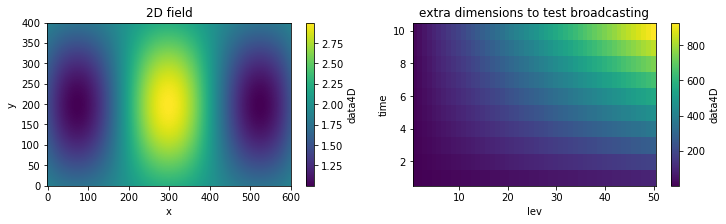

In [6]:
plt.figure(figsize=[12, 3])

plt.subplot(121)
ds_in['data4D'].isel(time=0, lev=0).plot()
plt.title('2D field')

plt.subplot(122)
ds_in['data4D'].mean(dim=['x','y']).plot()
plt.title('extra dimensions to test broadcasting')

## Build Regridder

Making a bilinear regridder takes ~7s on my Mac! (`'conservative'` would take even longer. Try it yourself.)

In [7]:
%%time
regridder = xe.Regridder(ds_in, ds_out, 'bilinear')

Create weight file: bilinear_400x600_300x400.nc
CPU times: user 7.15 s, sys: 458 ms, total: 7.61 s
Wall time: 7.72 s


In [8]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_400x600_300x400.nc 
Reuse pre-computed weights? False 
Input grid shape:           (400, 600) 
Output grid shape:          (300, 400) 
Output grid dimension name: ('y', 'x') 
Periodic in longitude?      False

## Apply regridding

However, applying the regridder to 1GB of data only takes ~0.5s

In [9]:
%%time
dr_out = regridder(ds_in['data4D'])

CPU times: user 429 ms, sys: 153 ms, total: 582 ms
Wall time: 586 ms


## Why applying regridding is so fast?

Most regridding algorithms (including all 5 algorithms in ESMF) are linear, i.e. the output data field is linearly dependent on the input data field. Any linear transform can be viewed as a matrix-vector multiplication $y = Ax$, where $A$ is a matrix containing **regridding weights**, and $x$, $y$ are input and output data fields flatten to 1D.

Computing the **weight matrix** $A$ is expensive, but $A$ **only depends on input and output grids**, not on input data. That means we can use the same $A$ on different input fields $x$, as long as the grid structure is not changed. 

An xESMF regridder has an attribute `A`, i.e. the weight matrix.

In [10]:
regridder.A

<120000x240000 sparse matrix of type '<class 'numpy.float64'>'
	with 480000 stored elements in COOrdinate format>

It is typically very sparse, because a single destination point will only receive contribution from a small number of source points.

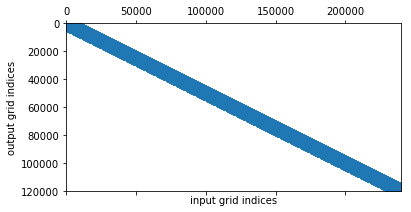

In [11]:
plt.spy(regridder.A)
plt.xlabel('input grid indices')
plt.ylabel('output grid indices')

## Retrieve regridder

When you open the notebook next time, instead of spending another ~7s on recomputing the weights, you can simply set `reuse_weights=True` to read existing weights from disk.

The weight file is typically pretty small (due to sparsity), so reading it is almost instantaneous.

In [12]:
%%bash
du -sh bilinear_400x600_300x400.nc

7.3M	bilinear_400x600_300x400.nc


In [13]:
%%time
regridder2 = xe.Regridder(ds_in, ds_out, 'bilinear', reuse_weights=True)

Reuse existing file: bilinear_400x600_300x400.nc
CPU times: user 23.4 ms, sys: 12.9 ms, total: 36.3 ms
Wall time: 36.2 ms


The second-step, applying those weights to data, is just a matrix multiplication $y=Ax$. With highly-optimized sparse matrix multiplication library, it is blazingly fast.

In [14]:
%%time
dr_out2 = regridder2(ds_in['data4D'])

CPU times: user 460 ms, sys: 164 ms, total: 624 ms
Wall time: 628 ms


The retrieved regridder gives the same result as the first regridder.

In [15]:
xr.testing.assert_identical(dr_out, dr_out2)  # they are equal

For even larger grids, you might spend several minutes computing the weights. But once they are computed, you don't have to do it again.

In [16]:
# don't have to clean it if you want to use it next time
regridder2.clean_weight_file()  

Remove file bilinear_400x600_300x400.nc
